Processing trajectories: 100%|██████████| 140000/140000 [00:00<00:00, 1133954.69it/s]


(280, 500, 2)
# of Unique Training Trajectories: 233
[ 0.192 -0.96 ]


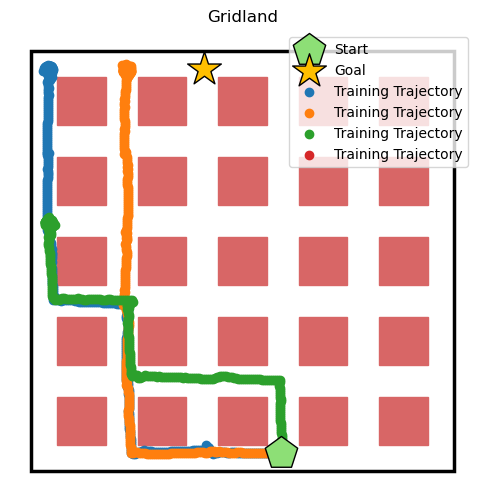

In [1]:
# imports, parameters, environment, etc.
import torch
import torch.nn as nn
from utilities.ogbench_utilities import *
from diffusion_planner import DiffusionPlannerConfig
from diffusion_planner import eval_model as diffusion_planer_eval
from utilities.cleandiffuser.invdynamic import MlpInvDynamic
from utilities.cleandiffuser.diffusion import ContinuousDiffusionSDE
from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE
from utilities.cleandiffuser.nn_diffusion import JannerUNet1d,CNN1dShiftEq,ConvNext1dShiftEq
from utilities.cleandiffuser.nn_condition import MLPCondition
from utilities.cleandiffuser.classifier import CumRewClassifier
from utilities.cleandiffuser.nn_classifier import HalfJannerUNet1d
from utilities.gridland_environment import *
from utilities.toy_env_utilities import ToyEnvInvDyn
import matplotlib.pyplot as plt
from matplotlib import colormaps


visualize = False
# start and end goal     # 2,0 -> 2,5 should be a novel S-A pair
start_idx = (3,0)
goal_idx = (2,5)
eval_sg_pair_list = [[(2, 5), (1, 0)], [(2, 5), (3, 0)], [(3, 0), (2, 5)], [(3, 0), (4, 5)], [(3, 0), (3, 5)], [(3, 5), (1, 0)], [(3, 5), (3, 0)], [(5, 2), (0, 1)], [(2, 0), (2, 5)], [(2, 0), (4, 5)], [(2, 0), (3, 5)]]

# various config parameters whatever
env = 'gridland'
n_size = 5
memory = 1
horizon = 512 # for generation so must be power of 2
num_envs = 500
num_episodes = 1
temperature = 0.5
n_exec_steps = 512
goal_inpaint_steps = 25
render = True

# gets the set of trajectories from the training data and various other stuff
import numpy as np 
from utilities.gridland_environment import *
from utilities.ogbench_utilities import GCSequenceDataset
config = DiffusionPlannerConfig()
config.horizon = 500
config.gen_horizon = 512
config.goal_sample_gamma = 0.99
config.allow_partial_subsamples = False
config.goal_padding = False
envs, dataset, _ = make_envs_and_datasets_gridland(n_size=5,num_envs = config.num_envs,goal_cond=True)
env = GridLand(n_size=5,timeout = 500)
env.reset(start_idx=start_idx,goal_idx=goal_idx)
train_dataset = GCSequenceDataset(dataset, config) # new sequence dataset
batch = train_dataset.sample(idxs=range(280)) # all the trajectories in training set


        

#batch = train_dataset.sample()
print(batch['observations'].shape)
traj_visitations = []
for trajectory in batch['observations']:
    visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
    traj_visitations.append(visited_intersections_idx)
    #print(trajectory)
training_trajectory_visitations = get_trajectory_sets(traj_visitations)
print('# of Unique Training Trajectories:',len(training_trajectory_visitations))

env = GridLand(n_size=n_size,timeout = 500)
env.reset(start_idx=start_idx,goal_idx=goal_idx)
print(env.start)
fig, ax = env.get_mpl_plot()
for trajectory,traj_idx in zip(batch['observations'],traj_visitations):
    if np.linalg.norm(trajectory[0,:] - env.start) < 0.1:
        #print(trajectory.shape)
        ax.scatter(trajectory[:,0],trajectory[:,1],label = 'Training Trajectory')
ax.legend()

In [2]:
# U-Net Regular
for sg_pair in eval_sg_pair_list:
    start_idx = sg_pair[0]
    goal_idx = sg_pair[1]
    ### Eq-Net, Unconditional
    # loads config, modifies to work w/given parameters
    config = DiffusionPlannerConfig()
    config.memory = memory
    config.horizon = horizon
    config.num_envs = num_envs
    config.num_episodes = num_episodes
    config.n_exec_steps = n_exec_steps
    config.env = env
    config.inpaint = True
    config.goal_inpaint_steps = goal_inpaint_steps
    config.gridland = True
    config.n_size = n_size
    config.pad = False
    config.gen_horizon = 512
    config.toy_env = True
    config.open_loop_invdyn = False
    config.guidance = 'none'
    config.goal_sample_dist = 'end'
    config.use_shift_equivariant_arch = False
    config.add_positional_encoding = False


    # loads environment
    envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
    obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]
    if config.use_shift_equivariant_arch:
            #nn_diffusion = ConvNext1dShiftEq(obs_dim)
            nn_diffusion = CNN1dShiftEq(obs_dim,
                                        kernel_expansion_rate=config.kernel_expansion_rate,
                                        model_dim = config.model_dim,
                                        emb_dim = config.emb_dim,
                                        encode_position=config.add_positional_encoding)
    else:
            nn_diffusion = JannerUNet1d(
            obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
            timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
            use_timestep_emb=config.use_timestep_embeddings)

    # creates classifier network if needed
    if 'classifier' in config.guidance:
            nn_classifier = HalfJannerUNet1d(
            config.gen_horizon, obs_dim + act_dim, out_dim=1,
            model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=config.task.dim_mult,
            timestep_emb_type="positional", kernel_size=3)
            classifier = CumRewClassifier(nn_classifier, device=config.device)
    else:
            classifier = None
    # creates condition network if needed (when using classifier-free guidance)
    if 'cfg' in config.guidance:
            nn_condition = MLPCondition(
            in_dim=obs_dim, out_dim=config.emb_dim, hidden_dims=[config.emb_dim, ], act=nn.SiLU(), dropout=config.label_dropout)
    else:
            nn_condition = None
    # ----------------- Masking ------------------- # some changes to remove gen. over actions
    # fix_mask that tells Diffusion model what parts of sequence to ignore during training
    # and which parts to inpaint with a prior during sampling. We'll only mask the first
    # state now (which should never be getting predicted from random)
    # but all others we keep during training, and then modify later during sampling.
    fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
    fix_mask[0, :] = 1. # for the starting/current state
    loss_weight = torch.ones((config.gen_horizon, obs_dim))

    # --------------- Diffusion Model --------------------
    agent = DiscreteDiffusionSDE(
            nn_diffusion = nn_diffusion, 
            nn_condition = nn_condition,
            classifier = classifier, 
            fix_mask=fix_mask, 
            loss_weight=loss_weight, 
            ema_rate=config.ema_rate,
            device=config.device,
            diffusion_steps=config.diffusion_steps, 
            predict_noise=config.predict_noise)

    # --------------- Inverse Dynamics --------------------
    if not config.toy_env:
            invdyn = MlpInvDynamic(obs_dim, act_dim, 512, nn.Tanh(), {"lr": 2e-4}, device=config.device)
            invdyn.load(config.invdyn_path)
            invdyn.eval()
    else:
            invdyn = ToyEnvInvDyn()
    #agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-4654c546diffusion_ckpt_latest.pt')
    #agent.load('trained_models/DP-EqNet-Uncond-Subseq-CondEnv-500k-gridland-n5-gc-988954fbdiffusion_ckpt_latest.pt')
    #agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-15fe4eb0diffusion_ckpt_150000.pt') # should be a quite decent model
    #agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-15fe4eb0diffusion_ckpt_250000.pt') # decent model at 250000
    #agent.load('trained_models/DP-EqNet-PosEnc-gridland-n5-gc-c5dec87ediffusion_ckpt_latest.pt') # v1 w/positional attention at 250000
    #agent.load('trained_models/DP-EqNet-SinPosEnc-gridland-n5-gc-9a5b6af0diffusion_ckpt_latest.pt') # v2 w/positional attention at 250000

    #agent.load('trained_models/DP-EqNet-Short-Sample-gridland-n5-gc-e66dc18fdiffusion_ckpt_latest.pt') # one trained on subsequences 1m steps

    #agent.load('trained_models/DP-UNet-pointmaze-giant-navigate-v0-6a5a1a58diffusion_ckpt_500000.pt')
    #agent.load('trained_models/DP-UNet-pointmaze-giant-navigate-v0-c0fec9bfdiffusion_ckpt_500000.pt')

    #agent.load('paper_models/DP-EqNet-gridland-n5-gc-9f810216diffusion_ckpt_latest.pt')

    agent.load('paper_models/DP-UNet-gridland-n5-gc-fed50478diffusion_ckpt_latest.pt')
    # Environment info 
    #print('==== Environment Info ====')
    #print('Name:',config.env)
    #print('Obs Space:',obs_dim)
    #print('Act Space:',act_dim)
    # main evaluation loop
    print('==== Running Eval ====')
    envs.reset(options={'start_idx':start_idx,'goal_idx':goal_idx})
    print('S/G Pair:',start_idx,goal_idx)
    avg_completion,trajectories, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
    #print(trajectories[0].shape)
    print('Avg. Completion:',avg_completion)

    if visualize:
        env = GridLand(n_size=n_size,timeout = 500)
        env.reset(start_idx=start_idx,goal_idx=goal_idx)
        fig, ax = env.get_mpl_plot()
        #print('replans',np.array(replans).shape)
        #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
        if num_envs == 1:
                ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='#e68d35',s=20,label='Executed Trajectory',alpha=1,zorder=100)
        else:
                ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
        #ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
        #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


        if num_envs == 1 and n_exec_steps != 512:
                replan_colors = colormaps['plasma_r']
                gradient = np.linspace(0, 1, len(replans[0]))
                for i,replan in enumerate(replans[0]):
                        #print(replan.shape)
                        ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)

        #print(trajectories[0].shape)
                visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
        #print(visited_intersections.shape)
                #ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
        #ax.legend()
        fig.set_dpi(100)

    traj_visitations = []
    trajectories = np.array(trajectories)
    trajectories = np.transpose(trajectories,(0,2,1,3))
    #print(trajectories.shape)
    reproduced_training_trajectories = 0
    for ep in trajectories:
            for trajectory in ep:
                    #print(trajectory.shape)
                    # ""fixes""" weird thing
                    for i, state in trajectory:
                            if np.linalg.norm(state-np.array([env.keypoints[goal_idx[0]],env.keypoints[goal_idx[1]]])) < 0.06:
                                    trajectory[i:,:] = state
                                    break
                    visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                    traj_visitations.append(visited_intersections_idx)
                    # stuff
                    this_trajectory_set = get_trajectory_sets([visited_intersections_idx])
                    if len(this_trajectory_set & training_trajectory_visitations) !=0:
                            reproduced_training_trajectories += 1
    generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
    filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=goal_idx)
    print('# of Training Trajectory Repeats',reproduced_training_trajectories)
    print('# of Unique Generated Trajectories:',len(generated_trajectory_visitations))
    print('# of New Generated Trajectories:', len(generated_trajectory_visitations-training_trajectory_visitations))
    print('% of Generated Trajectories Novel:', len(generated_trajectory_visitations-training_trajectory_visitations)/len(generated_trajectory_visitations))
    print('# of Unique Generated Successful Trajectories:',len(filtered_trajectories))
    #print('# of New Generated Succesful Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
    #print('% of Generated Succesful Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
    #training_trajectory_visitations

/root/generative-stitching/goal_stitching/utilities/cleandiffuser/diffusion/basic.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_loc

==== Running Eval ====
S/G Pair: (2, 5) (1, 0)


  0%|          | 0/1 [00:00<?, ?it/s]/root/generative-stitching/goal_stitching/diffusion_planner.py:388: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prior[:, -1, :obs_dim] = torch.tensor(goals,device=config.device) # inpaints goal state at end of trajectory
100%|██████████| 1/1 [00:25<00:00, 25.62s/it]


Avg. Completion: 0.0
# of Training Trajectory Repeats 500
# of Unique Generated Trajectories: 4
# of New Generated Trajectories: 0
% of Generated Trajectories Novel: 0.0
# of Unique Generated Successful Trajectories: 0
==== Running Eval ====
S/G Pair: (2, 5) (3, 0)


100%|██████████| 1/1 [00:26<00:00, 26.68s/it]


Avg. Completion: 0.0
# of Training Trajectory Repeats 500
# of Unique Generated Trajectories: 4
# of New Generated Trajectories: 0
% of Generated Trajectories Novel: 0.0
# of Unique Generated Successful Trajectories: 0
==== Running Eval ====
S/G Pair: (3, 0) (2, 5)


100%|██████████| 1/1 [00:27<00:00, 27.96s/it]


Avg. Completion: 0.0
# of Training Trajectory Repeats 500
# of Unique Generated Trajectories: 4
# of New Generated Trajectories: 0
% of Generated Trajectories Novel: 0.0
# of Unique Generated Successful Trajectories: 0
==== Running Eval ====
S/G Pair: (3, 0) (4, 5)


100%|██████████| 1/1 [00:26<00:00, 26.68s/it]


Avg. Completion: 0.0
# of Training Trajectory Repeats 500
# of Unique Generated Trajectories: 4
# of New Generated Trajectories: 0
% of Generated Trajectories Novel: 0.0
# of Unique Generated Successful Trajectories: 0
==== Running Eval ====
S/G Pair: (3, 0) (3, 5)


  0%|          | 0/1 [00:00<?, ?it/s]/root/miniconda3/envs/gen_stitch/lib/python3.9/site-packages/gymnasium/vector/async_vector_env.py:422: UserWarning: ERROR: Received the following error from Worker-455 - Shutting it down
  self._raise_if_errors(successes)
/root/miniconda3/envs/gen_stitch/lib/python3.9/site-packages/gymnasium/vector/async_vector_env.py:422: UserWarning: ERROR: Traceback (most recent call last):
  File "/root/miniconda3/envs/gen_stitch/lib/python3.9/site-packages/gymnasium/vector/async_vector_env.py", line 701, in _async_worker
    command, data = pipe.recv()
  File "/root/miniconda3/envs/gen_stitch/lib/python3.9/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/root/miniconda3/envs/gen_stitch/lib/python3.9/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/root/miniconda3/envs/gen_stitch/lib/python3.9/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
Keyb

In [3]:
# U-Net + Aug
for sg_pair in eval_sg_pair_list:
    start_idx = sg_pair[0]
    goal_idx = sg_pair[1]
    ### Eq-Net, Unconditional
    # loads config, modifies to work w/given parameters
    config = DiffusionPlannerConfig()
    config.memory = memory
    config.horizon = horizon
    config.num_envs = num_envs
    config.num_episodes = num_episodes
    config.n_exec_steps = n_exec_steps
    config.env = env
    config.inpaint = True
    config.goal_inpaint_steps = goal_inpaint_steps
    config.gridland = True
    config.n_size = n_size
    config.pad = False
    config.gen_horizon = 512
    config.toy_env = True
    config.open_loop_invdyn = False
    config.guidance = 'none'
    config.goal_sample_dist = 'end'
    config.use_shift_equivariant_arch = False
    config.add_positional_encoding = False


    # loads environment
    envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
    obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]
    if config.use_shift_equivariant_arch:
            #nn_diffusion = ConvNext1dShiftEq(obs_dim)
            nn_diffusion = CNN1dShiftEq(obs_dim,
                                        kernel_expansion_rate=config.kernel_expansion_rate,
                                        model_dim = config.model_dim,
                                        emb_dim = config.emb_dim,
                                        encode_position=config.add_positional_encoding)
    else:
            nn_diffusion = JannerUNet1d(
            obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
            timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
            use_timestep_emb=config.use_timestep_embeddings)

    # creates classifier network if needed
    if 'classifier' in config.guidance:
            nn_classifier = HalfJannerUNet1d(
            config.gen_horizon, obs_dim + act_dim, out_dim=1,
            model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=config.task.dim_mult,
            timestep_emb_type="positional", kernel_size=3)
            classifier = CumRewClassifier(nn_classifier, device=config.device)
    else:
            classifier = None
    # creates condition network if needed (when using classifier-free guidance)
    if 'cfg' in config.guidance:
            nn_condition = MLPCondition(
            in_dim=obs_dim, out_dim=config.emb_dim, hidden_dims=[config.emb_dim, ], act=nn.SiLU(), dropout=config.label_dropout)
    else:
            nn_condition = None
    # ----------------- Masking ------------------- # some changes to remove gen. over actions
    # fix_mask that tells Diffusion model what parts of sequence to ignore during training
    # and which parts to inpaint with a prior during sampling. We'll only mask the first
    # state now (which should never be getting predicted from random)
    # but all others we keep during training, and then modify later during sampling.
    fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
    fix_mask[0, :] = 1. # for the starting/current state
    loss_weight = torch.ones((config.gen_horizon, obs_dim))

    # --------------- Diffusion Model --------------------
    agent = DiscreteDiffusionSDE(
            nn_diffusion = nn_diffusion, 
            nn_condition = nn_condition,
            classifier = classifier, 
            fix_mask=fix_mask, 
            loss_weight=loss_weight, 
            ema_rate=config.ema_rate,
            device=config.device,
            diffusion_steps=config.diffusion_steps, 
            predict_noise=config.predict_noise)

    # --------------- Inverse Dynamics --------------------
    if not config.toy_env:
            invdyn = MlpInvDynamic(obs_dim, act_dim, 512, nn.Tanh(), {"lr": 2e-4}, device=config.device)
            invdyn.load(config.invdyn_path)
            invdyn.eval()
    else:
            invdyn = ToyEnvInvDyn()
    #agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-4654c546diffusion_ckpt_latest.pt')
    #agent.load('trained_models/DP-EqNet-Uncond-Subseq-CondEnv-500k-gridland-n5-gc-988954fbdiffusion_ckpt_latest.pt')
    #agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-15fe4eb0diffusion_ckpt_150000.pt') # should be a quite decent model
    #agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-15fe4eb0diffusion_ckpt_250000.pt') # decent model at 250000
    #agent.load('trained_models/DP-EqNet-PosEnc-gridland-n5-gc-c5dec87ediffusion_ckpt_latest.pt') # v1 w/positional attention at 250000
    #agent.load('trained_models/DP-EqNet-SinPosEnc-gridland-n5-gc-9a5b6af0diffusion_ckpt_latest.pt') # v2 w/positional attention at 250000

    #agent.load('trained_models/DP-EqNet-Short-Sample-gridland-n5-gc-e66dc18fdiffusion_ckpt_latest.pt') # one trained on subsequences 1m steps

    #agent.load('trained_models/DP-UNet-pointmaze-giant-navigate-v0-6a5a1a58diffusion_ckpt_500000.pt')
    #agent.load('trained_models/DP-UNet-pointmaze-giant-navigate-v0-c0fec9bfdiffusion_ckpt_500000.pt')

    #agent.load('paper_models/DP-EqNet-gridland-n5-gc-9f810216diffusion_ckpt_latest.pt')

    agent.load('paper_models/DP-UNet-PosAug-gridland-n5-gc-682c1254diffusion_ckpt_latest.pt')
    # Environment info 
    #print('==== Environment Info ====')
    #print('Name:',config.env)
    #print('Obs Space:',obs_dim)
    #print('Act Space:',act_dim)
    # main evaluation loop
    print('==== Running Eval ====')
    envs.reset(options={'start_idx':start_idx,'goal_idx':goal_idx})
    print('S/G Pair:',start_idx,goal_idx)
    avg_completion,trajectories, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
    #print(trajectories[0].shape)
    print('Avg. Completion:',avg_completion)

    if visualize:
        env = GridLand(n_size=n_size,timeout = 500)
        env.reset(start_idx=start_idx,goal_idx=goal_idx)
        fig, ax = env.get_mpl_plot()
        #print('replans',np.array(replans).shape)
        #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
        if num_envs == 1:
                ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='#e68d35',s=20,label='Executed Trajectory',alpha=1,zorder=100)
        else:
                ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
        #ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
        #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


        if num_envs == 1 and n_exec_steps != 512:
                replan_colors = colormaps['plasma_r']
                gradient = np.linspace(0, 1, len(replans[0]))
                for i,replan in enumerate(replans[0]):
                        #print(replan.shape)
                        ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)

        #print(trajectories[0].shape)
                visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
        #print(visited_intersections.shape)
                #ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
        #ax.legend()
        fig.set_dpi(100)

    traj_visitations = []
    trajectories = np.array(trajectories)
    trajectories = np.transpose(trajectories,(0,2,1,3))
    #print(trajectories.shape)
    reproduced_training_trajectories = 0
    for ep in trajectories:
            for trajectory in ep:
                    #print(trajectory.shape)
                    visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                    traj_visitations.append(visited_intersections_idx)
                    # stuff
                    this_trajectory_set = get_trajectory_sets([visited_intersections_idx])
                    if len(this_trajectory_set & training_trajectory_visitations) !=0:
                            reproduced_training_trajectories += 1
    generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
    filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=goal_idx)
    print('# of Training Trajectory Repeats',reproduced_training_trajectories)
    print('# of Unique Generated Trajectories:',len(generated_trajectory_visitations))
    print('# of New Generated Trajectories:', len(generated_trajectory_visitations-training_trajectory_visitations))
    print('% of Generated Trajectories Novel:', len(generated_trajectory_visitations-training_trajectory_visitations)/len(generated_trajectory_visitations))
    print('# of Unique Generated Successful Trajectories:',len(filtered_trajectories))
    #print('# of New Generated Succesful Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
    #print('% of Generated Succesful Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
    #training_trajectory_visitations

==== Running Eval ====
S/G Pair: (2, 5) (1, 0)


100%|██████████| 1/1 [00:26<00:00, 26.60s/it]


Avg. Completion: 0.0
# of Training Trajectory Repeats 24
# of Unique Generated Trajectories: 17
# of New Generated Trajectories: 15
% of Generated Trajectories Novel: 0.8823529411764706
# of Unique Generated Successful Trajectories: 0
==== Running Eval ====
S/G Pair: (2, 5) (3, 0)


100%|██████████| 1/1 [00:27<00:00, 27.28s/it]


Avg. Completion: 0.0
# of Training Trajectory Repeats 7
# of Unique Generated Trajectories: 30
# of New Generated Trajectories: 28
% of Generated Trajectories Novel: 0.9333333333333333
# of Unique Generated Successful Trajectories: 0
==== Running Eval ====
S/G Pair: (3, 0) (2, 5)


100%|██████████| 1/1 [00:26<00:00, 26.19s/it]


Avg. Completion: 0.0
# of Training Trajectory Repeats 298
# of Unique Generated Trajectories: 21
# of New Generated Trajectories: 17
% of Generated Trajectories Novel: 0.8095238095238095
# of Unique Generated Successful Trajectories: 0
==== Running Eval ====
S/G Pair: (3, 0) (4, 5)


100%|██████████| 1/1 [00:27<00:00, 27.27s/it]


Avg. Completion: 0.0
# of Training Trajectory Repeats 283
# of Unique Generated Trajectories: 21
# of New Generated Trajectories: 18
% of Generated Trajectories Novel: 0.8571428571428571
# of Unique Generated Successful Trajectories: 0
==== Running Eval ====
S/G Pair: (3, 0) (3, 5)


100%|██████████| 1/1 [00:27<00:00, 27.52s/it]


Avg. Completion: 0.0
# of Training Trajectory Repeats 328
# of Unique Generated Trajectories: 20
# of New Generated Trajectories: 16
% of Generated Trajectories Novel: 0.8
# of Unique Generated Successful Trajectories: 0
==== Running Eval ====
S/G Pair: (3, 5) (1, 0)


100%|██████████| 1/1 [00:27<00:00, 27.80s/it]


Avg. Completion: 0.0
# of Training Trajectory Repeats 3
# of Unique Generated Trajectories: 26
# of New Generated Trajectories: 25
% of Generated Trajectories Novel: 0.9615384615384616
# of Unique Generated Successful Trajectories: 0
==== Running Eval ====
S/G Pair: (3, 5) (3, 0)


100%|██████████| 1/1 [00:27<00:00, 27.62s/it]


Avg. Completion: 0.0
# of Training Trajectory Repeats 0
# of Unique Generated Trajectories: 24
# of New Generated Trajectories: 24
% of Generated Trajectories Novel: 1.0
# of Unique Generated Successful Trajectories: 0
==== Running Eval ====
S/G Pair: (5, 2) (0, 1)


100%|██████████| 1/1 [00:27<00:00, 27.39s/it]


Avg. Completion: 0.0
# of Training Trajectory Repeats 14
# of Unique Generated Trajectories: 39
# of New Generated Trajectories: 36
% of Generated Trajectories Novel: 0.9230769230769231
# of Unique Generated Successful Trajectories: 0
==== Running Eval ====
S/G Pair: (2, 0) (2, 5)


100%|██████████| 1/1 [00:26<00:00, 26.96s/it]


Avg. Completion: 0.004
# of Training Trajectory Repeats 280
# of Unique Generated Trajectories: 23
# of New Generated Trajectories: 21
% of Generated Trajectories Novel: 0.9130434782608695
# of Unique Generated Successful Trajectories: 1
==== Running Eval ====
S/G Pair: (2, 0) (4, 5)


100%|██████████| 1/1 [00:28<00:00, 28.43s/it]


Avg. Completion: 0.0
# of Training Trajectory Repeats 183
# of Unique Generated Trajectories: 26
# of New Generated Trajectories: 24
% of Generated Trajectories Novel: 0.9230769230769231
# of Unique Generated Successful Trajectories: 0
==== Running Eval ====
S/G Pair: (2, 0) (3, 5)


100%|██████████| 1/1 [00:24<00:00, 24.55s/it]


Avg. Completion: 0.0
# of Training Trajectory Repeats 259
# of Unique Generated Trajectories: 20
# of New Generated Trajectories: 18
% of Generated Trajectories Novel: 0.9
# of Unique Generated Successful Trajectories: 0


In [4]:
# Eq-Net +PosEnc
for sg_pair in eval_sg_pair_list:
    start_idx = sg_pair[0]
    goal_idx = sg_pair[1]
    ### Eq-Net, Unconditional
    # loads config, modifies to work w/given parameters
    config = DiffusionPlannerConfig()
    config.memory = memory
    config.horizon = horizon
    config.num_envs = num_envs
    config.num_episodes = num_episodes
    config.n_exec_steps = n_exec_steps
    config.env = env
    config.inpaint = True
    config.goal_inpaint_steps = goal_inpaint_steps
    config.gridland = True
    config.n_size = n_size
    config.pad = False
    config.gen_horizon = 512
    config.toy_env = True
    config.open_loop_invdyn = False
    config.guidance = 'none'
    config.goal_sample_dist = 'end'
    config.use_shift_equivariant_arch = True
    config.add_positional_encoding = True


    # loads environment
    envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
    obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]
    if config.use_shift_equivariant_arch:
            #nn_diffusion = ConvNext1dShiftEq(obs_dim)
            nn_diffusion = CNN1dShiftEq(obs_dim,
                                        kernel_expansion_rate=config.kernel_expansion_rate,
                                        model_dim = config.model_dim,
                                        emb_dim = config.emb_dim,
                                        encode_position=config.add_positional_encoding)
    else:
            nn_diffusion = JannerUNet1d(
            obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
            timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
            use_timestep_emb=config.use_timestep_embeddings)

    # creates classifier network if needed
    if 'classifier' in config.guidance:
            nn_classifier = HalfJannerUNet1d(
            config.gen_horizon, obs_dim + act_dim, out_dim=1,
            model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=config.task.dim_mult,
            timestep_emb_type="positional", kernel_size=3)
            classifier = CumRewClassifier(nn_classifier, device=config.device)
    else:
            classifier = None
    # creates condition network if needed (when using classifier-free guidance)
    if 'cfg' in config.guidance:
            nn_condition = MLPCondition(
            in_dim=obs_dim, out_dim=config.emb_dim, hidden_dims=[config.emb_dim, ], act=nn.SiLU(), dropout=config.label_dropout)
    else:
            nn_condition = None
    # ----------------- Masking ------------------- # some changes to remove gen. over actions
    # fix_mask that tells Diffusion model what parts of sequence to ignore during training
    # and which parts to inpaint with a prior during sampling. We'll only mask the first
    # state now (which should never be getting predicted from random)
    # but all others we keep during training, and then modify later during sampling.
    fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
    fix_mask[0, :] = 1. # for the starting/current state
    loss_weight = torch.ones((config.gen_horizon, obs_dim))

    # --------------- Diffusion Model --------------------
    agent = DiscreteDiffusionSDE(
            nn_diffusion = nn_diffusion, 
            nn_condition = nn_condition,
            classifier = classifier, 
            fix_mask=fix_mask, 
            loss_weight=loss_weight, 
            ema_rate=config.ema_rate,
            device=config.device,
            diffusion_steps=config.diffusion_steps, 
            predict_noise=config.predict_noise)

    # --------------- Inverse Dynamics --------------------
    if not config.toy_env:
            invdyn = MlpInvDynamic(obs_dim, act_dim, 512, nn.Tanh(), {"lr": 2e-4}, device=config.device)
            invdyn.load(config.invdyn_path)
            invdyn.eval()
    else:
            invdyn = ToyEnvInvDyn()
    #agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-4654c546diffusion_ckpt_latest.pt')
    #agent.load('trained_models/DP-EqNet-Uncond-Subseq-CondEnv-500k-gridland-n5-gc-988954fbdiffusion_ckpt_latest.pt')
    #agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-15fe4eb0diffusion_ckpt_150000.pt') # should be a quite decent model
    #agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-15fe4eb0diffusion_ckpt_250000.pt') # decent model at 250000
    #agent.load('trained_models/DP-EqNet-PosEnc-gridland-n5-gc-c5dec87ediffusion_ckpt_latest.pt') # v1 w/positional attention at 250000
    #agent.load('trained_models/DP-EqNet-SinPosEnc-gridland-n5-gc-9a5b6af0diffusion_ckpt_latest.pt') # v2 w/positional attention at 250000

    #agent.load('trained_models/DP-EqNet-Short-Sample-gridland-n5-gc-e66dc18fdiffusion_ckpt_latest.pt') # one trained on subsequences 1m steps

    #agent.load('trained_models/DP-UNet-pointmaze-giant-navigate-v0-6a5a1a58diffusion_ckpt_500000.pt')
    #agent.load('trained_models/DP-UNet-pointmaze-giant-navigate-v0-c0fec9bfdiffusion_ckpt_500000.pt')

    agent.load('paper_models/DP-EqNet-PosEnc-gridland-n5-gc-d36c72a4diffusion_ckpt_latest.pt')
    # Environment info 
    #print('==== Environment Info ====')
    #print('Name:',config.env)
    #print('Obs Space:',obs_dim)
    #print('Act Space:',act_dim)
    # main evaluation loop
    print('==== Running Eval ====')
    envs.reset(options={'start_idx':start_idx,'goal_idx':goal_idx})
    print('S/G Pair:',start_idx,goal_idx)
    avg_completion,trajectories, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
    #print(trajectories[0].shape)
    print('Avg. Completion:',avg_completion)

    if visualize:
        env = GridLand(n_size=n_size,timeout = 500)
        env.reset(start_idx=start_idx,goal_idx=goal_idx)
        fig, ax = env.get_mpl_plot()
        #print('replans',np.array(replans).shape)
        #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
        if num_envs == 1:
                ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='#e68d35',s=20,label='Executed Trajectory',alpha=1,zorder=100)
        else:
                ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
        #ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
        #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


        if num_envs == 1 and n_exec_steps != 512:
                replan_colors = colormaps['plasma_r']
                gradient = np.linspace(0, 1, len(replans[0]))
                for i,replan in enumerate(replans[0]):
                        #print(replan.shape)
                        ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)

        #print(trajectories[0].shape)
                visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
        #print(visited_intersections.shape)
                #ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
        #ax.legend()
        fig.set_dpi(100)

    traj_visitations = []
    trajectories = np.array(trajectories)
    trajectories = np.transpose(trajectories,(0,2,1,3))
    #print(trajectories.shape)
    reproduced_training_trajectories = 0
    for ep in trajectories:
            for trajectory in ep:
                    #print(trajectory.shape)
                    visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                    traj_visitations.append(visited_intersections_idx)
                    # stuff
                    this_trajectory_set = get_trajectory_sets([visited_intersections_idx])
                    if len(this_trajectory_set & training_trajectory_visitations) !=0:
                            reproduced_training_trajectories += 1
    generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
    filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=goal_idx)
    print('# of Training Trajectory Repeats',reproduced_training_trajectories)
    print('# of Unique Generated Trajectories:',len(generated_trajectory_visitations))
    print('# of New Generated Trajectories:', len(generated_trajectory_visitations-training_trajectory_visitations))
    print('% of Generated Trajectories Novel:', len(generated_trajectory_visitations-training_trajectory_visitations)/len(generated_trajectory_visitations))
    print('# of Unique Generated Successful Trajectories:',len(filtered_trajectories))
    #print('# of New Generated Succesful Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
    #print('% of Generated Succesful Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
    #training_trajectory_visitations

==== Running Eval ====
S/G Pair: (2, 5) (1, 0)


100%|██████████| 1/1 [00:39<00:00, 39.69s/it]


Avg. Completion: 0.032
# of Training Trajectory Repeats 132
# of Unique Generated Trajectories: 51
# of New Generated Trajectories: 49
% of Generated Trajectories Novel: 0.9607843137254902
# of Unique Generated Successful Trajectories: 7
==== Running Eval ====
S/G Pair: (2, 5) (3, 0)


100%|██████████| 1/1 [00:39<00:00, 39.18s/it]


Avg. Completion: 0.046
# of Training Trajectory Repeats 184
# of Unique Generated Trajectories: 60
# of New Generated Trajectories: 56
% of Generated Trajectories Novel: 0.9333333333333333
# of Unique Generated Successful Trajectories: 7
==== Running Eval ====
S/G Pair: (3, 0) (2, 5)


100%|██████████| 1/1 [00:43<00:00, 43.55s/it]


Avg. Completion: 0.046
# of Training Trajectory Repeats 140
# of Unique Generated Trajectories: 48
# of New Generated Trajectories: 45
% of Generated Trajectories Novel: 0.9375
# of Unique Generated Successful Trajectories: 8
==== Running Eval ====
S/G Pair: (3, 0) (4, 5)


100%|██████████| 1/1 [00:40<00:00, 40.61s/it]


Avg. Completion: 0.104
# of Training Trajectory Repeats 57
# of Unique Generated Trajectories: 52
# of New Generated Trajectories: 49
% of Generated Trajectories Novel: 0.9423076923076923
# of Unique Generated Successful Trajectories: 7
==== Running Eval ====
S/G Pair: (3, 0) (3, 5)


100%|██████████| 1/1 [00:39<00:00, 39.40s/it]


Avg. Completion: 0.044
# of Training Trajectory Repeats 62
# of Unique Generated Trajectories: 49
# of New Generated Trajectories: 47
% of Generated Trajectories Novel: 0.9591836734693877
# of Unique Generated Successful Trajectories: 9
==== Running Eval ====
S/G Pair: (3, 5) (1, 0)


100%|██████████| 1/1 [00:40<00:00, 40.20s/it]


Avg. Completion: 0.196
# of Training Trajectory Repeats 32
# of Unique Generated Trajectories: 54
# of New Generated Trajectories: 50
% of Generated Trajectories Novel: 0.9259259259259259
# of Unique Generated Successful Trajectories: 15
==== Running Eval ====
S/G Pair: (3, 5) (3, 0)


100%|██████████| 1/1 [00:39<00:00, 39.87s/it]


Avg. Completion: 0.162
# of Training Trajectory Repeats 35
# of Unique Generated Trajectories: 65
# of New Generated Trajectories: 61
% of Generated Trajectories Novel: 0.9384615384615385
# of Unique Generated Successful Trajectories: 15
==== Running Eval ====
S/G Pair: (5, 2) (0, 1)


100%|██████████| 1/1 [00:38<00:00, 38.40s/it]


Avg. Completion: 0.362
# of Training Trajectory Repeats 23
# of Unique Generated Trajectories: 55
# of New Generated Trajectories: 54
% of Generated Trajectories Novel: 0.9818181818181818
# of Unique Generated Successful Trajectories: 11
==== Running Eval ====
S/G Pair: (2, 0) (2, 5)


100%|██████████| 1/1 [00:39<00:00, 39.53s/it]


Avg. Completion: 0.086
# of Training Trajectory Repeats 98
# of Unique Generated Trajectories: 61
# of New Generated Trajectories: 59
% of Generated Trajectories Novel: 0.9672131147540983
# of Unique Generated Successful Trajectories: 10
==== Running Eval ====
S/G Pair: (2, 0) (4, 5)


100%|██████████| 1/1 [00:39<00:00, 39.77s/it]


Avg. Completion: 0.278
# of Training Trajectory Repeats 77
# of Unique Generated Trajectories: 56
# of New Generated Trajectories: 53
% of Generated Trajectories Novel: 0.9464285714285714
# of Unique Generated Successful Trajectories: 17
==== Running Eval ====
S/G Pair: (2, 0) (3, 5)


100%|██████████| 1/1 [00:42<00:00, 42.42s/it]


Avg. Completion: 0.136
# of Training Trajectory Repeats 63
# of Unique Generated Trajectories: 54
# of New Generated Trajectories: 52
% of Generated Trajectories Novel: 0.9629629629629629
# of Unique Generated Successful Trajectories: 13


In [6]:
# Eq-Net regular
for sg_pair in eval_sg_pair_list:
    start_idx = sg_pair[0]
    goal_idx = sg_pair[1]
    ### Eq-Net, Unconditional
    # loads config, modifies to work w/given parameters
    config = DiffusionPlannerConfig()
    config.memory = memory
    config.horizon = horizon
    config.num_envs = num_envs
    config.num_episodes = num_episodes
    config.n_exec_steps = n_exec_steps
    config.env = env
    config.inpaint = True
    config.goal_inpaint_steps = goal_inpaint_steps
    config.gridland = True
    config.n_size = n_size
    config.pad = False
    config.gen_horizon = 512
    config.toy_env = True
    config.open_loop_invdyn = False
    config.guidance = 'none'
    config.goal_sample_dist = 'end'
    config.use_shift_equivariant_arch = True
    config.add_positional_encoding = False


    # loads environment
    envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
    obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]
    if config.use_shift_equivariant_arch:
            #nn_diffusion = ConvNext1dShiftEq(obs_dim)
            nn_diffusion = CNN1dShiftEq(obs_dim,
                                        kernel_expansion_rate=config.kernel_expansion_rate,
                                        model_dim = config.model_dim,
                                        emb_dim = config.emb_dim,
                                        encode_position=config.add_positional_encoding)
    else:
            nn_diffusion = JannerUNet1d(
            obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
            timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
            use_timestep_emb=config.use_timestep_embeddings)

    # creates classifier network if needed
    if 'classifier' in config.guidance:
            nn_classifier = HalfJannerUNet1d(
            config.gen_horizon, obs_dim + act_dim, out_dim=1,
            model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=config.task.dim_mult,
            timestep_emb_type="positional", kernel_size=3)
            classifier = CumRewClassifier(nn_classifier, device=config.device)
    else:
            classifier = None
    # creates condition network if needed (when using classifier-free guidance)
    if 'cfg' in config.guidance:
            nn_condition = MLPCondition(
            in_dim=obs_dim, out_dim=config.emb_dim, hidden_dims=[config.emb_dim, ], act=nn.SiLU(), dropout=config.label_dropout)
    else:
            nn_condition = None
    # ----------------- Masking ------------------- # some changes to remove gen. over actions
    # fix_mask that tells Diffusion model what parts of sequence to ignore during training
    # and which parts to inpaint with a prior during sampling. We'll only mask the first
    # state now (which should never be getting predicted from random)
    # but all others we keep during training, and then modify later during sampling.
    fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
    fix_mask[0, :] = 1. # for the starting/current state
    loss_weight = torch.ones((config.gen_horizon, obs_dim))

    # --------------- Diffusion Model --------------------
    agent = DiscreteDiffusionSDE(
            nn_diffusion = nn_diffusion, 
            nn_condition = nn_condition,
            classifier = classifier, 
            fix_mask=fix_mask, 
            loss_weight=loss_weight, 
            ema_rate=config.ema_rate,
            device=config.device,
            diffusion_steps=config.diffusion_steps, 
            predict_noise=config.predict_noise)

    # --------------- Inverse Dynamics --------------------
    if not config.toy_env:
            invdyn = MlpInvDynamic(obs_dim, act_dim, 512, nn.Tanh(), {"lr": 2e-4}, device=config.device)
            invdyn.load(config.invdyn_path)
            invdyn.eval()
    else:
            invdyn = ToyEnvInvDyn()
    #agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-4654c546diffusion_ckpt_latest.pt')
    #agent.load('trained_models/DP-EqNet-Uncond-Subseq-CondEnv-500k-gridland-n5-gc-988954fbdiffusion_ckpt_latest.pt')
    #agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-15fe4eb0diffusion_ckpt_150000.pt') # should be a quite decent model
    #agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-15fe4eb0diffusion_ckpt_250000.pt') # decent model at 250000
    #agent.load('trained_models/DP-EqNet-PosEnc-gridland-n5-gc-c5dec87ediffusion_ckpt_latest.pt') # v1 w/positional attention at 250000
    #agent.load('trained_models/DP-EqNet-SinPosEnc-gridland-n5-gc-9a5b6af0diffusion_ckpt_latest.pt') # v2 w/positional attention at 250000

    #agent.load('trained_models/DP-EqNet-Short-Sample-gridland-n5-gc-e66dc18fdiffusion_ckpt_latest.pt') # one trained on subsequences 1m steps

    #agent.load('trained_models/DP-UNet-pointmaze-giant-navigate-v0-6a5a1a58diffusion_ckpt_500000.pt')
    #agent.load('trained_models/DP-UNet-pointmaze-giant-navigate-v0-c0fec9bfdiffusion_ckpt_500000.pt')

    agent.load('paper_models/DP-EqNet-gridland-n5-gc-9f810216diffusion_ckpt_latest.pt')
    # Environment info 
    #print('==== Environment Info ====')
    #print('Name:',config.env)
    #print('Obs Space:',obs_dim)
    #print('Act Space:',act_dim)
    # main evaluation loop
    print('==== Running Eval ====')
    envs.reset(options={'start_idx':start_idx,'goal_idx':goal_idx})
    print('S/G Pair:',start_idx,goal_idx)
    avg_completion,trajectories, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
    #print(trajectories[0].shape)
    print('Avg. Completion:',avg_completion)

    if visualize:
        env = GridLand(n_size=n_size,timeout = 500)
        env.reset(start_idx=start_idx,goal_idx=goal_idx)
        fig, ax = env.get_mpl_plot()
        #print('replans',np.array(replans).shape)
        #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
        if num_envs == 1:
                ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='#e68d35',s=20,label='Executed Trajectory',alpha=1,zorder=100)
        else:
                ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
        #ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
        #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


        if num_envs == 1 and n_exec_steps != 512:
                replan_colors = colormaps['plasma_r']
                gradient = np.linspace(0, 1, len(replans[0]))
                for i,replan in enumerate(replans[0]):
                        #print(replan.shape)
                        ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)

        #print(trajectories[0].shape)
                visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
        #print(visited_intersections.shape)
                #ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
        #ax.legend()
        fig.set_dpi(100)

    traj_visitations = []
    trajectories = np.array(trajectories)
    trajectories = np.transpose(trajectories,(0,2,1,3))
    #print(trajectories.shape)
    reproduced_training_trajectories = 0
    for ep in trajectories:
            for trajectory in ep:
                    #print(trajectory.shape)
                    # ""fixes""" weird thing
                    for i, state in enumerate(trajectory):
                            if np.linalg.norm(state-np.array([env.keypoints[goal_idx[0]],env.keypoints[goal_idx[1]]])) < 0.06:
                                    #print('meow')
                                    trajectory[i:,:] = state
                                    break
                    #print(trajectory.shape)
                    visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                    traj_visitations.append(visited_intersections_idx)
                    # stuff
                    this_trajectory_set = get_trajectory_sets([visited_intersections_idx])
                    if len(this_trajectory_set & training_trajectory_visitations) !=0:
                            reproduced_training_trajectories += 1
    generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
    filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=goal_idx)
    print('# of Training Trajectory Repeats',reproduced_training_trajectories)
    print('# of Unique Generated Trajectories:',len(generated_trajectory_visitations))
    print('# of New Generated Trajectories:', len(generated_trajectory_visitations-training_trajectory_visitations))
    print('% of Generated Trajectories Novel:', len(generated_trajectory_visitations-training_trajectory_visitations)/len(generated_trajectory_visitations))
    print('# of Unique Generated Successful Trajectories:',len(filtered_trajectories))
    #print('# of New Generated Succesful Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
    #print('% of Generated Succesful Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
    #training_trajectory_visitations

==== Running Eval ====
S/G Pair: (2, 5) (1, 0)


100%|██████████| 1/1 [00:40<00:00, 40.01s/it]


Avg. Completion: 0.638
# of Training Trajectory Repeats 20
# of Unique Generated Trajectories: 165
# of New Generated Trajectories: 162
% of Generated Trajectories Novel: 0.9818181818181818
# of Unique Generated Successful Trajectories: 108
==== Running Eval ====
S/G Pair: (2, 5) (3, 0)


100%|██████████| 1/1 [00:41<00:00, 41.76s/it]


Avg. Completion: 0.922
# of Training Trajectory Repeats 3
# of Unique Generated Trajectories: 154
# of New Generated Trajectories: 152
% of Generated Trajectories Novel: 0.987012987012987
# of Unique Generated Successful Trajectories: 125
==== Running Eval ====
S/G Pair: (3, 0) (2, 5)


100%|██████████| 1/1 [00:39<00:00, 39.73s/it]


Avg. Completion: 0.924
# of Training Trajectory Repeats 2
# of Unique Generated Trajectories: 136
# of New Generated Trajectories: 134
% of Generated Trajectories Novel: 0.9852941176470589
# of Unique Generated Successful Trajectories: 104
==== Running Eval ====
S/G Pair: (3, 0) (4, 5)


100%|██████████| 1/1 [00:41<00:00, 41.77s/it]


Avg. Completion: 0.764
# of Training Trajectory Repeats 12
# of Unique Generated Trajectories: 143
# of New Generated Trajectories: 141
% of Generated Trajectories Novel: 0.986013986013986
# of Unique Generated Successful Trajectories: 98
==== Running Eval ====
S/G Pair: (3, 0) (3, 5)


100%|██████████| 1/1 [00:40<00:00, 40.65s/it]


Avg. Completion: 0.92
# of Training Trajectory Repeats 3
# of Unique Generated Trajectories: 139
# of New Generated Trajectories: 137
% of Generated Trajectories Novel: 0.9856115107913669
# of Unique Generated Successful Trajectories: 115
==== Running Eval ====
S/G Pair: (3, 5) (1, 0)


100%|██████████| 1/1 [00:41<00:00, 41.07s/it]


Avg. Completion: 0.67
# of Training Trajectory Repeats 6
# of Unique Generated Trajectories: 156
# of New Generated Trajectories: 153
% of Generated Trajectories Novel: 0.9807692307692307
# of Unique Generated Successful Trajectories: 105
==== Running Eval ====
S/G Pair: (3, 5) (3, 0)


100%|██████████| 1/1 [00:41<00:00, 41.26s/it]


Avg. Completion: 0.948
# of Training Trajectory Repeats 0
# of Unique Generated Trajectories: 135
# of New Generated Trajectories: 135
% of Generated Trajectories Novel: 1.0
# of Unique Generated Successful Trajectories: 115
==== Running Eval ====
S/G Pair: (5, 2) (0, 1)


100%|██████████| 1/1 [00:40<00:00, 40.77s/it]


Avg. Completion: 0.924
# of Training Trajectory Repeats 1
# of Unique Generated Trajectories: 151
# of New Generated Trajectories: 150
% of Generated Trajectories Novel: 0.9933774834437086
# of Unique Generated Successful Trajectories: 122
==== Running Eval ====
S/G Pair: (2, 0) (2, 5)


100%|██████████| 1/1 [00:40<00:00, 40.26s/it]


Avg. Completion: 0.924
# of Training Trajectory Repeats 5
# of Unique Generated Trajectories: 134
# of New Generated Trajectories: 133
% of Generated Trajectories Novel: 0.9925373134328358
# of Unique Generated Successful Trajectories: 108
==== Running Eval ====
S/G Pair: (2, 0) (4, 5)


100%|██████████| 1/1 [00:41<00:00, 41.66s/it]


Avg. Completion: 0.726
# of Training Trajectory Repeats 19
# of Unique Generated Trajectories: 202
# of New Generated Trajectories: 201
% of Generated Trajectories Novel: 0.995049504950495
# of Unique Generated Successful Trajectories: 141
==== Running Eval ====
S/G Pair: (2, 0) (3, 5)


100%|██████████| 1/1 [00:46<00:00, 46.17s/it]


Avg. Completion: 0.89
# of Training Trajectory Repeats 29
# of Unique Generated Trajectories: 155
# of New Generated Trajectories: 153
% of Generated Trajectories Novel: 0.9870967741935484
# of Unique Generated Successful Trajectories: 124


## Below - code to generate the evaluation pair list


In [6]:
## hardest variant - start and goal do not appear in any training trajectory (sequentially) - so stitching required
# grabs all start-goal pairs
# gets a list of all border keypoints to work as start/stop states
border_keypoint_list = set()
for x_keypoint in range(len(env.keypoints)):
    for y_keypoint in range(len(env.keypoints)):
        keypoint = tuple((x_keypoint,y_keypoint))
        if 0 in keypoint or n_size in keypoint:
            border_keypoint_list.add(keypoint)

# finds list of legitimate start-goal pairs, such that 
# a] the S-G pair isn't in the training data
# b] the G or S pair doesn't happen to be visited in the same trajectory 
eval_sg_pair_list = []
for start in tqdm(border_keypoint_list):
    for goal in border_keypoint_list:
        start_coords = np.array((env.keypoints[start[0]],env.keypoints[start[1]]))
        goal_coords = np.array((env.keypoints[goal[0]],env.keypoints[goal[1]]))
        both_seen = False
        for trajectory in batch['observations']:
            start_seen = False
            goal_seen = False
            for i in range(500):
                if np.linalg.norm(trajectory[i,:] - start_coords) < 0.1:
                    start_seen = True
                if np.linalg.norm(trajectory[i,:] - goal_coords) < 0.1 and start_seen:
                    goal_seen = True
            if start_seen and goal_seen:
                both_seen = True
        #print(both_seen)
        if not both_seen:
            eval_sg_pair_list.append([start,goal])
print(len(eval_sg_pair_list))

100%|██████████| 20/20 [03:27<00:00, 10.35s/it]

11
